##### Neural Net with Multiple Neurons

Now let's take one step towards further complexity by increasing the size of our hidden layer. Before, we had only one neuron; let's add a second, and then generalize the architecture so that the *width* of the net (the number of neurons) can be flexibly specified. 

Along the way, let's make two other changes from before. First, this time we will create data that has some degree of nonlinearity, and we will see if the NN provides a significant boost from the OLS results. Second, we will add in a *bias* rather than including a constant data point.

First, let's go ahead and generate some data, similar to before but with a nonlinearity included. This time, we will make it so that $Y \in (0,1)$ from the start, and save ourselves from having to do any normalization.

In [76]:
# Bring in necessary packages
import numpy as np
from scipy.stats import norm

# Set seed
np.random.seed(3172024)

# Generate the U variable uniformly distributed between -1 and 1
U = np.random.uniform(0, 2, (300, 1))

# Generate the categorical variable
B = np.random.choice([0, 1], size=(300, 1), p=[0.7, 0.3])

# Draw an error
e = norm.rvs(size=(300,1), scale = .05)

# set an intercept b0 and slopes b1 and b2
b0 = .2
b1= .25
b2 = .15
b3 = .02
truecoef = [b0, b1, b2]

# Generate our Y variable
Y = b0 + b1*U + b2*B + b3*np.abs(np.cos(4*U)) + e
data = np.concatenate((U, B, Y), axis=1)

# print the min and max of Y
print("the min of Y is", np.min(Y), "and the max of Y is", np.max(Y))


the min of Y is 0.17123483775659482 and the max of Y is 0.8610144237423343


(300,)
(300, 1)
(300, 1)


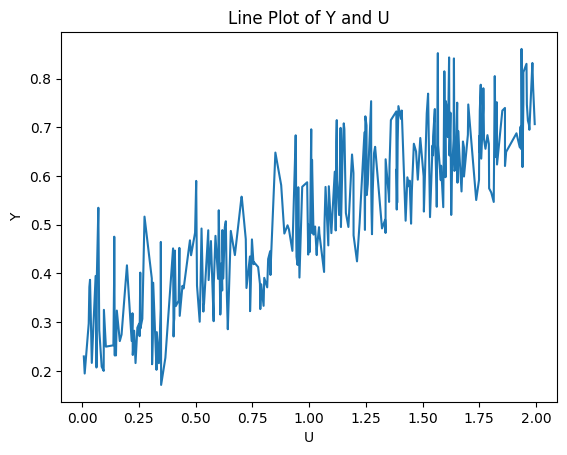

In [77]:
# graph:
import matplotlib.pyplot as plt

# Sort the U and Y values by U
sorted_indices = np.argsort(U.flatten())
print(sorted_indices.shape)
print(U.shape)
print(Y.shape)
sorted_U = U[sorted_indices]
sorted_Y = Y[sorted_indices]

# Create the line plot
plt.plot(sorted_U, sorted_Y)
plt.xlabel('U')
plt.ylabel('Y')
plt.title('Line Plot of Y and U')
plt.show()

We go ahead and split into training and validation sets:

In [78]:
# size of training set:
train_size = round(0.8 * data.shape[0])

# size of validation set:
val_size   = data.shape[0] - train_size

# Get indices for the training set
# indices = np.random.choice(range(0, data.shape[0]), size=train_size, replace=False)
indices = np.random.choice(range(data.shape[0]), size=train_size, replace=False)
valindices = np.setdiff1d(np.arange(data.shape[0]), indices)

# Use these indices to create the training set
train_data = data[indices,:]

# Use the remaining indices for the validation set
val_data = data[valindices,:]

Now, let's go get our OLS coefficients to compare against. Note that stats model has a command to add a constant that we can take advantage of for the regression.

In [79]:
# bring in package for OLS
import statsmodels.api as sm

# X variables:
X = train_data[:,0:2]
# Y variable:
Y = train_data[:,2].reshape(-1, 1)

# Run regression with a constant term added
OLS = sm.OLS(Y, sm.add_constant(X))
resultsOLS = OLS.fit()

# save these coefficients:
OLScoef = resultsOLS.params

print("The OLS coefficients are ", OLScoef, "compared to the true values of ", truecoef)

The OLS coefficients are  [0.21902044 0.24128173 0.14324583] compared to the true values of  [0.2, 0.25, 0.15]


By design, the OLS regression now struggles to recover the true parameters. The treatment effect of $U$ is well estimated but the intercept appears biased upwards and the coefficient for U biased downwards. This is thanks to the nonlinear $\lvert \cos (X) \rvert $ term which we included.

Now let's try and estimate the model using a neural net. Last time, we had a hidden layer with just one neuron. We know this is equivalent to estimating $Y$ as:

$$
\hat{Y_i} = \sigma(\bf{w \cdot x_i})
$$

Where the only parameters to set were the weights $w$, which solve:

$$
\text{min}_w \sum_{i=1}^{N} \dfrac{(\hat{y}_i - y_i)^2}{2} = \text{min}_w L
$$

Now we can add a second cell, which is a second sigmoid function taking a different dot product of $X$. We then add these two values together with their own weights $\alpha$. So we are now predicting $Y$ as:

$$
\hat{Y_i} = \alpha_1 \sigma(\bf{w_1 \cdot x_i}) + \alpha_2 \sigma(\bf{w_2 \cdot x_i})
$$

Where we now find the weight matrix $\bf{w}$ and the vector $\bf{\alpha}$ to solve the same minimization problem.

It may seem weird to be adding two separate sigmoids together, but this will allow us to more flexibly capture different features of the data. Imagine that our DGP consisted of two nonlinear functions:

$$
f(x) = g(x) + l(x)
$$

Above, we were using one sigmoid to approximate the sum of these two functions, while we now allow the network to model them separately.

In [92]:
# create a neural network class
class NeuralNetwork:
    # Initialize variables
    def __init__(self, X, Y):
        self.input      = X
        self.output     = Y
        # initialize weights for one hidden layer
        self.weights1    = np.random.rand(self.input.shape[1],2) 
        self.weights2    = np.random.rand(2,1)
        self.error_history = []
        self.learning_rate = 0.00001

    # Activation function
    # let's use sigmoid, with the derivative built in
    def sigmoid(self, x, derivative=False):
        if derivative:
            return (1 / (1 + np.exp(-x)))*(1- (1 / (1 + np.exp(-x))))
        return 1 / (1 + np.exp(-x))
    
    # data move through the network: take the dot product of inputs and weights, then feed it into the sigmoid function
    def feed_forward(self):
        self.neuron1 = self.sigmoid(np.dot(self.input, self.weights1[:,0]))
        self.neuron2 = self.sigmoid(np.dot(self.input, self.weights1[:,1]))
        self.hidden  = (self.weights2[0,0]*self.neuron1 + self.weights2[1,0]*self.neuron2)
        self.hidden=self.hidden.reshape(-1,1)

    # then go backwards through the network to update weights
    def backpropagation(self):
        # error between prediction and actual
        self.error  = self.output - self.hidden
        # first update the weights in the output layer
        delta_outer = self.error * self.hidden
        # update innerweights
        delta_inner1 = self.error * self.sigmoid(self.neuron1, derivative=True).reshape(-1,1) * self.weights2[0,0]
        delta_inner2 = self.error * self.sigmoid(self.neuron2, derivative=True).reshape(-1,1) * self.weights2[1,0]
        # print(self.input.T.shape, delta_inner2.shape)        
        # print(np.dot(self.input.T, delta_inner1))
        # print(np.dot(self.input.T, delta_inner1).shape)
        # print(self.weights1[:,0].shape)
        self.weights1[:,0] += self.learning_rate*np.dot(self.input.T, delta_inner1).squeeze()
        self.weights1[:,1] += self.learning_rate*np.dot(self.input.T, delta_inner2).squeeze()
        # update outer weights
        self.weights2[0,0] += self.learning_rate*np.dot(self.neuron1.T, delta_outer)
        self.weights2[1,0] += self.learning_rate*np.dot(self.neuron2.T, delta_outer)

    # define a training function:
    def train(self, epochs=40000):
        for _ in range(epochs):
            # flow forward and produce an output
            self.feed_forward()
            # go back though the network to make corrections based on the output -- eg gradient descent
            self.backpropagation()    
            # We can track our improvement across epochs:
            self.error_history.append(np.average(np.abs(self.error)))
    
    # function to predict output                               
    def predict(self, new_input):
        prediction = self.weights2[0,0] * self.sigmoid(np.dot(new_input, self.weights1[:,0])) + self.weights2[1,0] * self.sigmoid(np.dot(new_input, self.weights1[:,1]))
        return prediction


In [97]:
# create neural network   
NN = NeuralNetwork(X, Y.reshape(-1,1))
# train neural network
NN.train()

[[-0.08449091 -0.07963926 -0.21857192 ... -0.07074965 -0.12917923
  -0.24289235]
 [-0.01813112 -0.01327947 -0.15221213 ... -0.00438986 -0.06281944
  -0.17653256]
 [ 0.15187516  0.15672681  0.01779414 ...  0.16561642  0.10718684
  -0.00652628]
 ...
 [-0.1014053  -0.09655365 -0.23548631 ... -0.08766404 -0.14609362
  -0.25980674]
 [-0.01117368 -0.00632203 -0.14525469 ...  0.00256758 -0.055862
  -0.16957512]
 [ 0.23681762  0.24166927  0.10273661 ...  0.25055888  0.1921293
   0.07841618]]


In [104]:
NNpred  = NN.predict(X)
NNdiff = NNpred - Y.squeeze()
NNdiff

array([-0.08449091, -0.01327947,  0.01779414, -0.0683082 , -0.03347587,
        0.02602892,  0.09646349,  0.16101636,  0.08718224, -0.15411283,
       -0.02072933,  0.03853133,  0.06253636,  0.19308233,  0.13226302,
       -0.15145534, -0.0315246 ,  0.03836629,  0.00576031, -0.0757461 ,
        0.11415193,  0.17700088,  0.12396952, -0.07215611,  0.10889129,
        0.13092363, -0.09764572, -0.08559546, -0.00350541, -0.06774576,
        0.08928613,  0.11571593,  0.09050273, -0.0521291 , -0.00531842,
       -0.11564913, -0.14068318,  0.1001152 ,  0.15222333,  0.12824711,
        0.00907967,  0.07776645, -0.01802611, -0.04885271,  0.14360197,
        0.01969232, -0.0656891 ,  0.15532616,  0.01347689, -0.03050379,
       -0.03830933, -0.02693725, -0.10363371,  0.04804971, -0.06784586,
        0.05324871,  0.04999206,  0.05754917, -0.02227729,  0.12835421,
        0.03130832,  0.14117969,  0.07095414,  0.11113399,  0.06940797,
       -0.08530091,  0.20443907, -0.18299842, -0.01061955,  0.15

The OLS MSE is 0.002295401913169935 and the NN SSE is 0.009307140968606192
The OLS SSE is 0.5508964591607843 and the NN SSE is 2.233713832465486


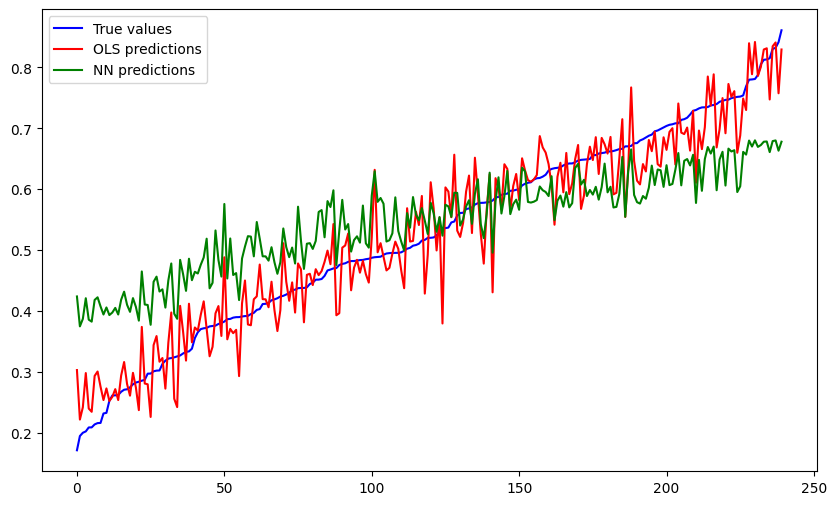

0.17123483775659482 0.8610144237423343
            Y   OLSpred    NNpred
158  0.171235  0.302972  0.423861
234  0.194645  0.221695  0.374732
142  0.200002  0.241880  0.387030
165  0.202235  0.298054  0.420932
21   0.208749  0.239777  0.385750
83   0.208837  0.234423  0.382489
66   0.213691  0.293361  0.418130
204  0.215856  0.300600  0.422449
229  0.216111  0.275753  0.407558
213  0.231666  0.253706  0.394218


In [105]:
import pandas as pd

# calculate predictions from both models
NNpred  = NN.predict(X)
OLSpred = OLScoef[0] + np.dot(X, OLScoef[1:3])

# calculate errors
OLSerror = OLSpred - Y.squeeze()
NNerror = NNpred - Y.squeeze()

# sum of squared errors
OLSSSE = np.sum(OLSerror**2)
NNSSE = np.sum(NNerror**2)
# mean squared error
ols_mse = np.mean(OLSerror**2)
nn_mse = np.mean(NNerror**2)

# now let's plot
data = pd.DataFrame({
    'Y': Y.squeeze(),
    'OLSpred': OLSpred.squeeze(),
    'NNpred': NNpred.squeeze()
})

print("The OLS MSE is", ols_mse, "and the NN SSE is", nn_mse)
print("The OLS SSE is", OLSSSE, "and the NN SSE is", NNSSE)

# Sort the data by Y_scaled
data.sort_values('Y', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Y'].values, 'b', label='True values')
plt.plot(data['OLSpred'].values, 'r', label='OLS predictions')
plt.plot(data['NNpred'].values, 'g', label='NN predictions')
plt.legend()
plt.show()

print(np.min(Y), np.max(Y))
print(data.iloc[0:10])